## Estimating or specifying parameters in state space models

In this notebook we show how to fix specific values of certain parameters in statsmodels' state space models while estimating others.

In general, state space models allow users to:

1. Estimate all parameters by maximum likelihood
2. Fix some parameters and estimate the rest
3. Fix all parameters (so that no parameters are estimated)


In [1]:
%matplotlib inline

from importlib import reload
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader

To illustrate, we will use the Consumer Price Index for Apparel, which has a time-varying level and a strong seasonal component.

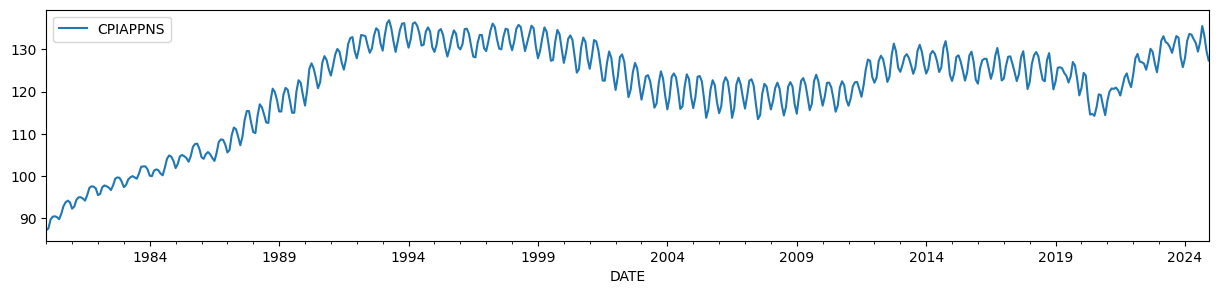

In [2]:
endog = DataReader('CPIAPPNS', 'fred', start='1980').asfreq('MS')
endog.plot(figsize=(15, 3));

It is well known (e.g. Harvey and Jaeger [1993]) that the HP filter output can be generated by an unobserved components model given certain restrictions on the parameters.

The unobserved components model is:

$$
\begin{aligned}
y_t & = \mu_t + \varepsilon_t & \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
\mu_t &= \mu_{t-1} + \beta_{t-1} + \eta_t & \eta_t \sim N(0, \sigma_\eta^2) \\
\beta_t &= \beta_{t-1} + \zeta_t & \zeta_t \sim N(0, \sigma_\zeta^2) \\
\end{aligned}
$$

For the trend to match the output of the HP filter, the parameters must be set as follows:

$$
\begin{aligned}
\frac{\sigma_\varepsilon^2}{\sigma_\zeta^2} & = \lambda \\
\sigma_\eta^2 & = 0
\end{aligned}
$$

where $\lambda$ is the parameter of the associated HP filter. For the monthly data that we use here, it is usually recommended that $\lambda = 129600$.

In [3]:
# Run the HP filter with lambda = 129600
hp_cycle, hp_trend = sm.tsa.filters.hpfilter(endog, lamb=129600)

# The unobserved components model above is the local linear trend, or "lltrend", specification
mod = sm.tsa.UnobservedComponents(endog, 'lltrend')
print(mod.param_names)

['sigma2.irregular', 'sigma2.level', 'sigma2.trend']


The parameters of the unobserved components model (UCM) are written as:

- $\sigma_\varepsilon^2 = \text{sigma2.irregular}$
- $\sigma_\eta^2 = \text{sigma2.level}$
- $\sigma_\zeta^2 = \text{sigma2.trend}$

To satisfy the above restrictions, we will set $(\sigma_\varepsilon^2, \sigma_\eta^2, \sigma_\zeta^2) = (1, 0, 1 / 129600)$.

Since we are fixing all parameters here, we do not need to use the `fit` method at all, since that method is used to perform maximum likelihood estimation. Instead, we can directly run the Kalman filter and smoother at our chosen parameters using the `smooth` method.

In [4]:
res = mod.smooth([1., 0, 1. / 129600])
print(res.summary())

                        Unobserved Components Results                         
Dep. Variable:               CPIAPPNS   No. Observations:                  540
Model:             local linear trend   Log Likelihood               -3024.471
Date:                Mon, 20 Jan 2025   AIC                           6054.943
Time:                        16:10:46   BIC                           6067.806
Sample:                    01-01-1980   HQIC                          6059.974
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     1.0000      0.009    117.123      0.000       0.983       1.017
sigma2.level              0      0.000          0      1.000      -0.000       0.000
sigma2.trend      7.716e-06 

The estimate that corresponds to the HP filter's trend estimate is given by the smoothed estimate of the `level` (which is $\mu_t$ in the notation above):

In [5]:
ucm_trend = pd.Series(res.level.smoothed, index=endog.index)

It is easy to see that the estimate of the smoothed level from the UCM is equal to the output of the HP filter:

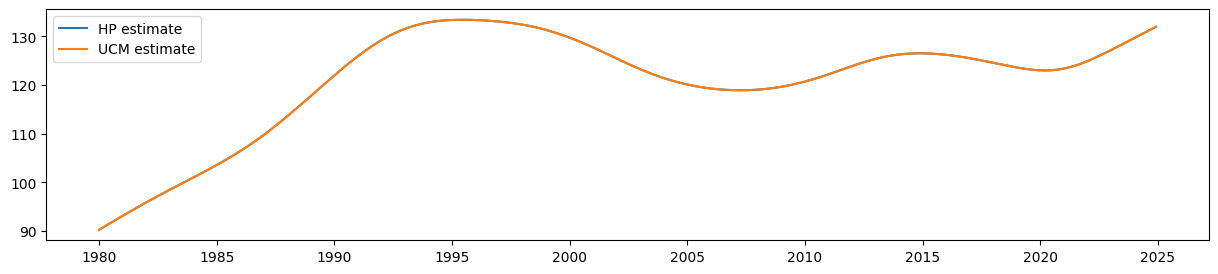

In [6]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(hp_trend, label='HP estimate')
ax.plot(ucm_trend, label='UCM estimate')
ax.legend();

### Adding a seasonal component

However, unobserved components models are more flexible than the HP filter. For example, the data shown above is clearly seasonal, but with time-varying seasonal effects (the seasonality is much weaker at the beginning than at the end). One of the benefits of the unobserved components framework is that we can add a stochastic seasonal component. In this case, we will estimate the variance of the seasonal component by maximum likelihood while still including the restriction on the parameters implied above so that the trend corresponds to the HP filter concept.

Adding the stochastic seasonal component adds one new parameter, `sigma2.seasonal`.

In [7]:
# Construct a local linear trend model with a stochastic seasonal component of period 1 year
mod = sm.tsa.UnobservedComponents(endog, 'lltrend', seasonal=12, stochastic_seasonal=True)
print(mod.param_names)

['sigma2.irregular', 'sigma2.level', 'sigma2.trend', 'sigma2.seasonal']


In this case, we will continue to restrict the first three parameters as described above, but we want to estimate the value of `sigma2.seasonal` by maximum likelihood. Therefore, we will use the `fit` method along with the `fix_params` context manager.

The `fix_params` method takes a dictionary of parameters names and associated values. Within the generated context, those parameters will be used in all cases. In the case of the `fit` method, only the parameters that were not fixed will be estimated.

In [8]:
# Here we restrict the first three parameters to specific values
with mod.fix_params({'sigma2.irregular': 1, 'sigma2.level': 0, 'sigma2.trend': 1. / 129600}):
    # Now we fit any remaining parameters, which in this case
    # is just `sigma2.seasonal`
    res_restricted = mod.fit()

Alternatively, we could have simply used the `fit_constrained` method, which also accepts a dictionary of constraints:

In [9]:
res_restricted = mod.fit_constrained({'sigma2.irregular': 1, 'sigma2.level': 0, 'sigma2.trend': 1. / 129600})

The summary output includes all parameters, but indicates that the first three were fixed (and so were not estimated).

In [10]:
print(res_restricted.summary())

                            Unobserved Components Results                            
Dep. Variable:                      CPIAPPNS   No. Observations:                  540
Model:                    local linear trend   Log Likelihood               -1754.140
                   + stochastic seasonal(12)   AIC                           3510.280
Date:                       Mon, 20 Jan 2025   BIC                           3514.547
Time:                               16:10:47   HQIC                          3511.951
Sample:                           01-01-1980                                         
                                - 12-01-2024                                         
Covariance Type:                         opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
sigma2.irregular (fixed)     1.0000     

For comparison, we construct the unrestricted maximum likelihood estimates (MLE). In this case, the estimate of the level will no longer correspond to the HP filter concept.

In [11]:
res_unrestricted = mod.fit()

Finally, we can retrieve the smoothed estimates of the trend and seasonal components.

In [12]:
# Construct the smoothed level estimates
unrestricted_trend = pd.Series(res_unrestricted.level.smoothed, index=endog.index)
restricted_trend = pd.Series(res_restricted.level.smoothed, index=endog.index)

# Construct the smoothed estimates of the seasonal pattern
unrestricted_seasonal = pd.Series(res_unrestricted.seasonal.smoothed, index=endog.index)
restricted_seasonal = pd.Series(res_restricted.seasonal.smoothed, index=endog.index)

Comparing the estimated level, it is clear that the seasonal UCM with fixed parameters still produces a trend that corresponds very closely (although no longer exactly) to the HP filter output.

Meanwhile, the estimated level from the model with no parameter restrictions (the MLE model) is much less smooth than these.

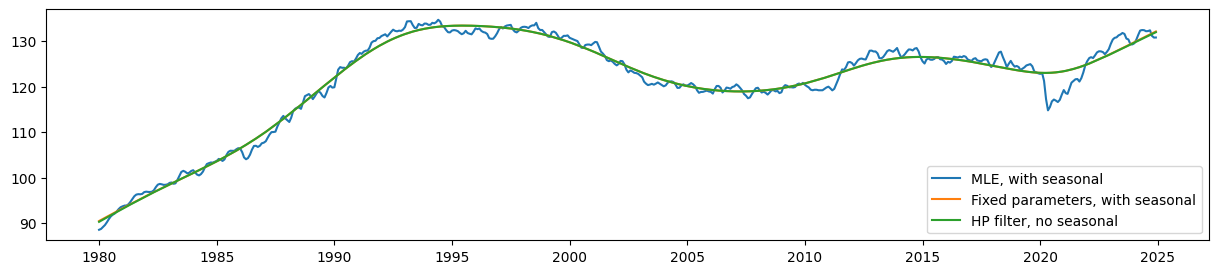

In [13]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(unrestricted_trend, label='MLE, with seasonal')
ax.plot(restricted_trend, label='Fixed parameters, with seasonal')
ax.plot(hp_trend, label='HP filter, no seasonal')
ax.legend();

Finally, the UCM with the parameter restrictions is still able to pick up the time-varying seasonal component quite well.

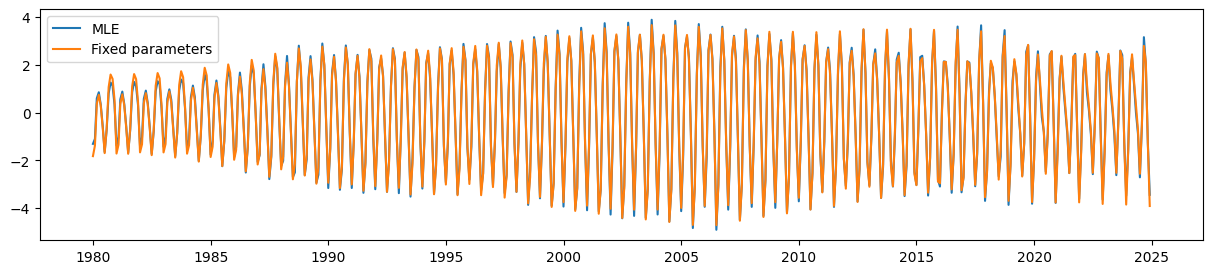

In [14]:
fig, ax = plt.subplots(figsize=(15, 3))

ax.plot(unrestricted_seasonal, label='MLE')
ax.plot(restricted_seasonal, label='Fixed parameters')
ax.legend();